In [1]:
# Import statements
import os
import traceback
import pickle
import pdb
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from LearningSession import *
from LearningChoicePredictor import *
from LearningPsychometricPredictor import *
from sklearn.linear_model import LogisticRegression
import ssm

## Load Results

In [2]:
def greatest_state_occupancy(hmm, X, y):
    states = hmm.most_likely_states(
        y, input=X
        )
    unique_states = np.unique(states)
    occupancies = []
    for s in unique_states:
        occupancies.append(np.sum(states == s))
    return max(occupancies)/(1.*states.size)

In [27]:
def predict(hmm, X, y):
    states = hmm.most_likely_states(
        y, input=X
        )
    transition_matrix = hmm.transitions.transition_matrix
    pred_y = []
    for idx, x in enumerate(X):
        if idx == 0:
            continue

        input_with_constant = np.hstack(
            (x, 1)
            )
        prev_state = states[idx - 1]
        transition_probs = transition_matrix[prev_state,:]
        expected_ps = 0
        
        # Overestimate:
#         curr_state = states[idx]
#         logit_ps = input_with_constant @ hmm.observations.coef[curr_state]
#         ps = 1/(1 + np.exp(-1*logit_ps))
#         expected_ps = ps
        
        # Underestimate
        for new_state, transition_prob in enumerate(transition_probs):
            logit_ps = input_with_constant @ hmm.observations.coef[new_state]
            ps = 1/(1 + np.exp(-1*logit_ps))
            expected_ps += ps*transition_prob
            
        if expected_ps > 0.5:
            pred_y.append(1)
        else:
            pred_y.append(0)
    return np.array(pred_y)

In [4]:
def plot_glm_weights(coefs, task):
    if task == "aud":
        coef_types = ["Prev Choice", "Stim Delta", "Prev Rewarded", "Bias"]
    else:
        coef_types = ["Prev Choice", "Stim Delta", "Prev Rewarded", "Prev Aud/Tac", "Bias"]
    plt.figure()
    for idx, coef in enumerate(coefs):
        plt.plot(coef/max(coef), label="State %d"%(idx - 1))
    plt.xticks(np.arange(coef.size), coef_types)
    plt.ylabel("GLM Weight")
    plt.axhline(0, color="black")
    plt.legend()
    plt.show()

In [12]:
def get_data_matrix(task_type):
    animal = 'mSM63'
    folder = '/home/chingf/engram/data/musall/learning/neural/mSM63'
    dates = os.listdir(folder)
    dates.sort()
    dates = dates[1:]
    dates.sort(key = lambda date: datetime.strptime(date, '%d-%b-%Y'))
    
    # Load choice decoding results
    choicedecoders = pickle.load(
        open("pickles/choicedecodingreduce1.0_learning_mSM63.p", "rb")
        )
    
    aud_dates = range(21, 31)
    audtac_dates = range(31, 41)
    tacaud_dates = range(41, 68)
    if task_type == "aud":
        task_dates = aud_dates
        multimodal = False
    elif task_type == "audtac":
        task_dates = audtac_dates
        multimodal = True
    elif task_type == "tacaud":
        task_dates = tacaud_dates
        multimodal = True
    all_X = []
    all_y = []
    all_indices = []
    is_aud_trial = []
    curr_index = 0

    for date_idx, day_number in enumerate(task_dates):
        date = dates[day_number]
        session = LearningSession(
            animal, date, access_engram=True, load_neural=False
            )
        predictor = LearningPsychometricPredictor(
            session, multimodal=multimodal)
        
        # Collect behavioral covariates
        y = predictor.trial_choices
        X = predictor.data
        
        # Add in choice decoder predictive probability
        # Frames 0-10 are pre-stim, 10-30 are during stim, 30-40 are post-stim
        choicedecoder = choicedecoders[day_number]
        predic_probs = []
        for trial in range(1, session.num_trials + 1):
            trial_predic_probs = []
            for frame in range(len(choicedecoder["predic_prob"])):
                prob = choicedecoder["predic_prob"][frame]
                trial_labels = choicedecoder["trial_labels"][frame]
                idx = np.argwhere(trial_labels == trial)
                if idx.size == 0:
                    trial_predic_probs.append(np.nan)
                else:
                    trial_predic_probs.append(prob[idx, 1][0,0])
            trial_predic_probs = np.array(trial_predic_probs)
            predic_probs.append(trial_predic_probs)
        predic_probs = np.array(predic_probs)
        pre_stim_prob = np.mean(predic_probs[:,:10], axis=1)
        X = np.hstack((X, pre_stim_prob.reshape((-1,1))))
        
        # Post-process predictors: throw out nan trials
        nonnan_covariates = np.logical_not(
            np.sum(np.isnan(X), axis=1)
            )
        nonnan_choices = np.logical_not(np.isnan(y))
        nonnan_indices = np.logical_and(nonnan_covariates, nonnan_choices)
        y = y[nonnan_indices].astype(int) - 1
        y = y.reshape((-1,1))
        X = X[nonnan_indices,:]
        
        # Boolean mask over auditory trials for nonnan trials
        for idx, val in enumerate(nonnan_indices):
            if not val:
                continue
            is_aud_trial.append(session.is_aud_trial[idx])
            
        # Collect into arrays over all relevant sessions
        indices = np.vstack(
            (np.arange(y.size) + curr_index, np.ones(y.size)*date_idx)
            ).T
        all_X.append(X)
        all_y.append(y)
        all_indices.append(indices)
        curr_index += y.size
    all_X = np.vstack(all_X)
    all_y = np.vstack(all_y)
    all_indices = np.vstack(all_indices)
    
    # For testing/debugging
    all_X = all_X[:,-1].reshape((-1,1))
    
    return all_X, all_y

In [6]:
def plot_psychometric_clf(clf, task):
    if task == "aud":
        condition_names = [
            "L; Rewarded",
            "L; Unrewarded",
            "R; Rewarded",
            "R; Unrewarded"
            ]
        condition_styles = ["-b", "--b", "-r", "--r"]
        condition_inputs = [
            [0, np.nan, 1], [0, np.nan, 0], [1, np.nan, 1], [1, np.nan, 0]
            ]
        plt.figure()
        for idx, cond_name in enumerate(condition_names):
            cond_in = condition_inputs[idx]
            cond_style = condition_styles[idx]
            delta_idx = cond_in.index(np.nan)
            X = []
            for delta in range(-35, 36):
                cond_in[delta_idx] = delta
                X.append([i for i in cond_in])
            X = np.array(X)
            
            # Norm
#             X = X.astype(float)
#             X[:,1] = X[:,1]/30.
            
            psych_curve = clf.predict_proba(X)
            plt.plot(
                range(-35, 36), psych_curve[:,1],
                cond_style, label=cond_name
                )
        plt.title("Probability of Choosing Right")
        plt.legend()
        plt.xlabel("More Left Beeps >>> More Right Beeps")
        plt.ylim((0,1))
        plt.axhline(0.5, color="gray")
        plt.axvline(0, color="gray")
        plt.show()
    else:
        condition_names = [
            "L; Rewarded; Aud",
            "L; Unrewarded; Aud",
            "R; Rewarded; Aud",
            "R; Unrewarded; Aud",
            "L; Rewarded; Tac",
            "L; Unrewarded; Tac",
            "R; Rewarded; Tac",
            "R; Unrewarded; Tac"
            ]
        condition_styles = [
            "-b", "--b", "-r", "--r", "-b", "--b", "-r", "--r"
            ]
        condition_inputs = [
            [0, np.nan, 1, 1], [0, np.nan, 0, 1], [1, np.nan, 1, 1], [1, np.nan, 0, 1],
            [0, np.nan, 1, 0], [0, np.nan, 0, 0], [1, np.nan, 1, 0], [1, np.nan, 0, 0]
            ]
        
        fig, axs = plt.subplots(1,2, figsize=(12,4))
        for ax_idx, ax in enumerate(axs):
            condition_idxs = np.arange(ax_idx*4, ax_idx*4 + 4)
            for condition_idx in condition_idxs:
                cond_name = condition_names[condition_idx]
                cond_in = condition_inputs[condition_idx]
                cond_style = condition_styles[condition_idx]
                delta_idx = cond_in.index(np.nan)
                X = []
                for delta in range(-35, 36):
                    cond_in[delta_idx] = delta
                    X.append([i for i in cond_in])
                X = np.array(X)
                psych_curve = clf.predict_proba(X)
                ax.plot(
                    range(-35, 36), psych_curve[:,1],
                    cond_style, label=cond_name
                    )
            modality = ["Aud", "Tac"]
            ax.set_title(
                "Prob. of Choosing Right\nPrevious " + modality[ax_idx] + " Trial"
                )
            ax.set_xlabel("More Left Beeps >>> More Right Beeps")
            ax.set_ylim((0,1))
            ax.axhline(0.5, color="gray")
            ax.axvline(0, color="gray")
        plt.legend()
        plt.show()

def plot_psychometric_coefs(coefs, task):
    for coef in coefs:
        clf = LogisticRegression()
        clf.coef_ = np.array([coef[:-1]])
        clf.intercept_ = np.array([coef[-1]])
        plot_psychometric_clf(clf, task)

In [7]:
def find_best_p_weight(results_init):
    """
    Assuming results is a dictionary over prior weights. Each entry
    of the dictionary is a list of 20 runs of the GLMHMM
    """
    
    best_init = None
    best_p_weight = None
    best_score = -np.inf
    for init in results_init.keys():
        results = results_init[init]
        for p_weight in results.keys():
            sample_glmhmms = results[p_weight]
            sample_scores = [s['test_ll'] for s in sample_glmhmms]
            score = max(sample_scores)
            if score > best_score:
                best_init = init
                best_p_weight = p_weight
                best_score = score
    return best_init, best_p_weight

In [9]:
task = "aud"
filename = "habanero_results/" + task
results_K = pickle.load(open(
    filename + "_neurglmhmm_testresults.p", "rb"
    ))
filename = "habanero_data/" + task
data = pickle.load(open(
    filename + "_neurglmhmm_testdata.p", "rb"
    ))

## Test performance as a function of latent dimension

In [23]:
# Collect log likelihoods
X, y = get_data_matrix(task)
test_lls = []
pred_scores = []
occupancies = []
Ks = []
Ks_p_weights = []
Ks_inits = []
for K in results_K.keys():
    init, p_weight = find_best_p_weight(results_K[K])
    results = results_K[K][init][p_weight]
    Ks_p_weights.append(p_weight)
    Ks_inits.append(init)
    for result in results:
        train_indices = result['train_indices'].astype(int)
        test_indices = result['test_indices'].astype(int)
        hmm = result['hmm']
        test_lls.append(result['test_ll']/test_indices.shape[0])
        
        X_test = X[test_indices[:,0]]
        y_test = y[test_indices[:,0]]
        pred_choices = predict(hmm, X_test, y_test)
        true_choices = y_test.flatten()[1:]
        pred_score = np.sum(pred_choices == true_choices)/true_choices.size
        pred_scores.append(pred_score)
        
        occ = greatest_state_occupancy(hmm, X, y)
        occupancies.append(occ)
        
        Ks.append(K)
df = pd.DataFrame({
    'Ks': Ks, 'test_lls': test_lls, 'pred_scores': pred_scores, 'occupancies': occupancies
    })

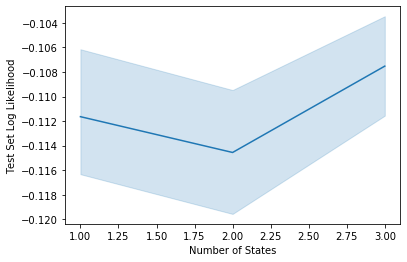

In [24]:
# Plot Log-Likes as a function of dimensions
sns.lineplot(
    x="Ks", y="test_lls", data=df
    )
plt.ylabel("Test Set Log Likelihood")
plt.xlabel("Number of States")
plt.show()

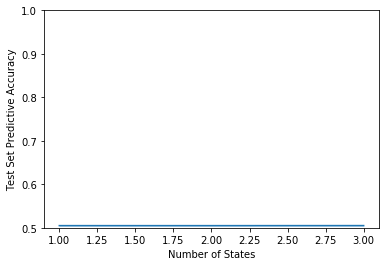

In [25]:
# Plot Log-Likes as a function of dimensions
sns.lineplot(
    x="Ks", y="pred_scores", data=df
    )
plt.ylabel("Test Set Predictive Accuracy")
plt.xlabel("Number of States")
plt.ylim(0.5, 1)
plt.show()

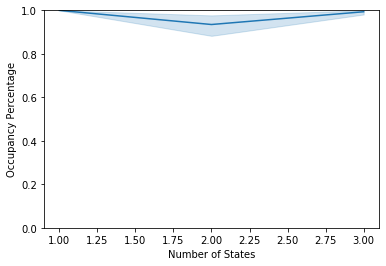

In [26]:
# Plot state occupancy as a function of dimensions
sns.lineplot(
    x="Ks", y="occupancies", data=df
    )
plt.ylabel("Occupancy Percentage")
plt.xlabel("Number of States")
plt.ylim(0,1)
plt.show()

In [17]:
Ks_p_weights

[0.01, 0.001, 0.01]

In [18]:
K = 2
p_weight = Ks_p_weights[K - 1]
init = Ks_inits[K - 1]
results = results_K[K][init][p_weight]
results_test_lls = [r['test_ll'] + max(r['lls']) for r in results]
best_result = results[np.argmax(results_test_lls)]
hmm = best_result['hmm']

## Comparing inferred GLM Weights

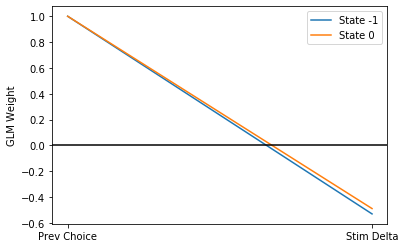

In [21]:
plot_glm_weights(hmm.observations.coef, task)

## Comparing inferred psychometric curves

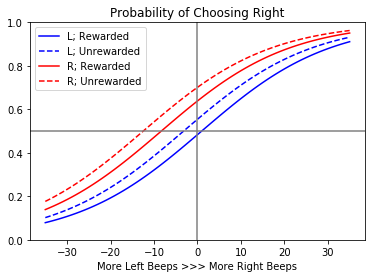

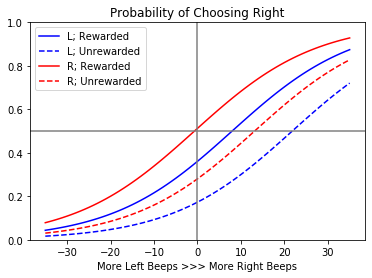

In [78]:
plot_psychometric_coefs(hmm.observations.coef, task)

## Testing accuracy: predicted states and predicted choices

In [85]:
train_indices = best_result['train_indices'].astype(int)
test_indices = best_result['test_indices'].astype(int)
X, y = get_data_matrix(task)
X_train = X[train_indices[:,0]]
y_train = y[train_indices[:,0]]
X_test = X[test_indices[:,1]]
y_test = y[test_indices[:,1]]

In [86]:
predicted_test = hmm.most_likely_states(
    y_test, input=X_test
    ) + 1
predicted_train = hmm.most_likely_states(
    y_train, input=X_train
    ) + 1

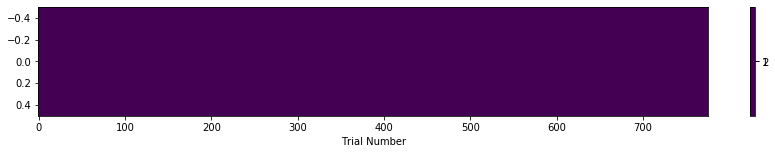

In [87]:
plt.figure(figsize=(15,2))
plt.imshow(
    predicted_test.reshape((1,-1)),
    aspect="auto")
plt.xlabel("Trial Number")
plt.colorbar(boundaries=np.arange(K+1)+0.5, ticks=np.arange(K)+1)
plt.show()

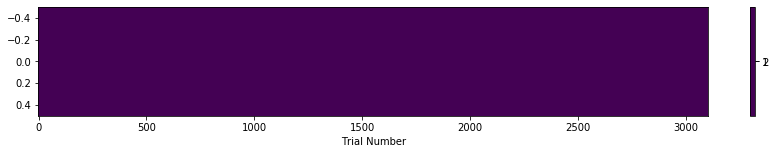

In [88]:
plt.figure(figsize=(15,2))
plt.imshow(
    predicted_train.reshape((1,-1)),
    aspect="auto")
plt.xlabel("Trial Number")
plt.colorbar(boundaries=np.arange(K+1)+0.5, ticks=np.arange(K)+1)
plt.show()

## Generating Data

In [44]:
animal = 'mSM63'
folder = '/home/chingf/engram/data/musall/learning/neural/mSM63'
dates = os.listdir(folder)
dates.sort()
dates = dates[1:]
dates.sort(key = lambda date: datetime.strptime(date, '%d-%b-%Y')) 

In [51]:
# Create dataset
def _form_data_matrix(task_type):
    aud_dates = dates[21:31]
    audtac_dates = dates[31:41]
    tacaud_dates = dates[41:68]
    if task_type == "aud":
        task_dates = aud_dates
        multimodal = False
    elif task_type == "audtac":
        task_dates = audtac_dates
        multimodal = True
    elif task_type == "tacaud":
        task_dates = tacaud_dates
        multimodal = True
    all_X = []
    all_y = []
    all_indices = []
    is_aud_trial = []
    curr_index = 0

    for date_idx, date in enumerate(task_dates):
        session = LearningSession(
            animal, date, access_engram=True, load_neural=False
            )
        predictor = LearningPsychometricPredictor(
            session, multimodal=multimodal)
        trial_choices = predictor.trial_choices
        nonnan_choices = np.logical_not(np.isnan(trial_choices))
        nonnan_data = np.ones((nonnan_choices.shape)).astype(bool)
        for trial in range(predictor.data.shape[0]):
            if np.sum(np.isnan(predictor.data[trial,:])) > 0:
                nonnan_data[trial] = False
        nonnan_indices = np.logical_and(nonnan_choices, nonnan_data)
        y = trial_choices[nonnan_indices].astype(int) - 1
        y = y.reshape((-1,1))
        X = predictor.data[nonnan_indices,:]
        for idx, val in enumerate(nonnan_indices):
            if not val:
                continue
            is_aud_trial.append(session.is_aud_trial[idx])
        indices = np.vstack(
            (np.arange(y.size) + curr_index, np.ones(y.size)*date_idx)
            ).T
        all_X.append(X)
        all_y.append(y)
        all_indices.append(indices)
        curr_index += y.size
    all_X = np.vstack(all_X)
    all_y = np.vstack(all_y)
    all_indices = np.vstack(all_indices)
    if task_type == "aud":
        filename = task_type + "_glmhmm_data.p"
        _split_data_and_save(all_X, all_y, all_indices, filename)
    else:
        is_tac_trial = np.logical_not(is_aud_trial)
        aud_filename = task_type + "_aud_glmhmm_data.p"
        aud_X = all_X[is_aud_trial]
        aud_y = all_y[is_aud_trial]
        aud_indices = all_indices[is_aud_trial]
        _split_data_and_save(
            aud_X, aud_y, aud_indices, aud_filename
            )
        tac_filename = task_type + "_tac_glmhmm_data.p"
        tac_X = all_X[is_tac_trial]
        tac_y = all_y[is_tac_trial]
        tac_indices = all_indices[is_tac_trial]
        _split_data_and_save(
            tac_X, tac_y, tac_indices, tac_filename
            )
    
def _split_data_and_save(all_X, all_y, all_indices, filename):
    data = {
        "X": all_X, "y": all_y, "indices": all_indices
        }
    pickle.dump(data, open(filename, "wb"))

In [52]:
task_type = "aud"
_form_data_matrix(task_type)
task_type = "audtac"
_form_data_matrix(task_type)
task_type = "tacaud"
_form_data_matrix(task_type)